In [5]:
!pip install tensorflow==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import tensorflow as tf
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-efbf28fb-93b1-e938-e2b5-0a55d9c39e66)


## Get Helper Function

In [9]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-18 05:45:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-18 05:45:54 (72.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Use Tensorflow Dataset to download the data

In [10]:
# Get TensorFlow dataset
import tensorflow_datasets as tfds

In [11]:
# List all available datasets
dataset_list = tfds.list_builders() # get all available dataset in tfds
print("food101" in dataset_list) # Is our target dataset in the list of TFDS datasets?

True


In [12]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=['train','validation'],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tupple format (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteCR0FIG/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteCR0FIG/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

To become one with the data, I want to find:

* Class names
* The shape of the input data (image tensors)
* The datatype of my input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [13]:
# Feature of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [14]:
# Get the class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [15]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [16]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image Shape: {image.shape},
  Image Datatype: {image.dtype},
  Traget Class from Food101 (tensor form): {label},
  Class Name (str form): {class_names[label.numpy()]}""")


  Image Shape: (384, 512, 3),
  Image Datatype: <dtype: 'uint8'>,
  Traget Class from Food101 (tensor form): 56,
  Class Name (str form): huevos_rancheros


In [17]:
# What does our image tensor from TSDS's Food101 look like?
image

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [144,  81, 102],
        [142,  78, 102],
        [139,  75,  99]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [159,  96, 115],
        [154,  89, 111],
        [146,  83, 104]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [162,  98, 114],
        [162,  95, 113],
        [157,  93, 110]],

       ...,

       [[ 75,  32,  16],
        [ 77,  34,  17],
        [ 78,  35,  19],
        ...,
        [ 99,  31,  20],
        [104,  32,  20],
        [106,  34,  20]],

       [[ 81,  34,  18],
        [ 81,  34,  16],
        [ 82,  35,  19],
        ...,
        [102,  33,  26],
        [104,  36,  27],
        [109,  39,  31]],

       [[ 79,  30,  13],
        [ 80,  31,  14],
        [ 81,  32,  15],
        ...,
        [113,  46,  4

In [18]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from TensorFlow Datasests

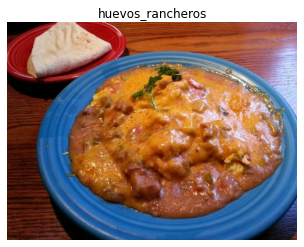

In [19]:
# Plot an image tensor
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create Preprocessing Function for the data

In [20]:
def preprocess_img(image, label, img_shape=224):
  """
  Convert image datatype from 'unit8' -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label # return (float_image, label) tuple

In [21]:
# Preprocess a single sample image & check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [144  81 102]
  [142  78 102]
  [139  75  99]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [159  96 115]
  [154  89 111]
  [146  83 104]]]..., 
Shape: (384, 512, 3), 
Datatype: <dtype: 'uint8'>
Image after preprocessing:
 [[[  0.         0.         0.      ]
  [  0.         0.         0.      ]
  [  0.         0.         0.      ]
  ...
  [157.23973   91.24997  110.18368 ]
  [150.2857    86.622444 107.239784]
  [144.57637   80.47435  103.6325  ]]

 [[  0.         0.         0.      ]
  [  0.         0.         0.      ]
  [  0.         0.         0.      ]
  ...
  [157.85226   91.70941  105.097206]
  [164.45404   97.72448  114.3112  ]
  [159.09677   93.16319  110.545815]]]..., 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


## Batch & Prepare datasets

In [22]:
# Map preprocessing function to training data (and parellelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train data & turn into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [23]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

## Create Modelling Callbacks

I'm going to create a couple of callbacks to help me while my model trains:
* **TensorBoard callback** to log training results (so I can visualize them later if need be)
* **ModelCheckpoint callback** to save my model's preogress after feature extraction
* The **EarlyStopping callback** monitors a specified model performance metric (e.g. val_loss) and when it stops improving for a specified number of epochs, automatically stops training.
* Like the ModelCheckpoint and EarlyStopping callbacks, the **ReduceLROnPlateau callback** montiors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor (e.g. divides the learning rate by 10).

In [24]:
# Create TensorBoard callback
from helper_functions import create_tensorboard_callback

# Create Modelcheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoint/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training
                                                  
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

## Setup mixed precision training

In [25]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [26]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build Feature Tuning Model

In [27]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create Base Model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Unfreeze all the layers in the base model
base_model.trainable=True


# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

16711680/16705208 [==============================] - 0s 0us/step


In [28]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [29]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"])

## Checking Layer dtype policies (Is it Mixed Precision?)

In [30]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


## Fit the Feature Tunining Model

In [31]:
history = model.fit(train_data,
                    epochs=20,
                    steps_per_epoch=(len(train_data)),
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                           experiment_name="efficientnet_101_classes_all_data_feature_tuning"),
                               model_checkpoint,
                               early_stopping,
                               reduce_lr])

Saving TensorBoard log files to: training_logs/efficientnet_101_classes_all_data_feature_tuning/20220818-055432
Epoch 1/20
2368/2368 [==============================] - 389s 153ms/step - loss: 2.8828 - accuracy: 0.3628 - val_loss: 0.8598 - val_accuracy: 0.7728


Epoch 2/20
2368/2368 [==============================] - 362s 152ms/step - loss: 1.0819 - accuracy: 0.7174 - val_loss: 0.6761 - val_accuracy: 0.8133


Epoch 3/20
2368/2368 [==============================] - 361s 151ms/step - loss: 0.7651 - accuracy: 0.7957 - val_loss: 0.6253 - val_accuracy: 0.8239


Epoch 4/20
2368/2368 [==============================] - 362s 152ms/step - loss: 0.5846 - accuracy: 0.8405 - val_loss: 0.6070 - val_accuracy: 0.8377


Epoch 5/20
2368/2368 [==============================] - 360s 151ms/step - loss: 0.4444 - accuracy: 0.8768 - val_loss: 0.6052 - val_accuracy: 0.8390


Epoch 6/20
2368/2368 [==============================] - 361s 152ms/step - loss: 0.3404 - accuracy: 0.9062 - val_loss: 0.6332 - val_accuracy: 0.8308


Epoch 7/20
2368/2368 [==============================] - 362s 152ms/step - loss: 0.2679 - accuracy: 0.9263 - val_loss: 0.6537 - val_accuracy: 0.8316



Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 8/20
2368/2368 [==============================] - 361s 152ms/step - loss: 0.1859 - accuracy: 0.9507 - val_loss: 0.6026 - val_accuracy: 0.8438


Epoch 9/20
2368/2368 [==============================] - 361s 152ms/step - loss: 0.1483 - accuracy: 0.9608 - val_loss: 0.6098 - val_accuracy: 0.8461


Epoch 10/20
2368/2368 [==============================] - 361s 152ms/step - loss: 0.1338 - accuracy: 0.9666 - val_loss: 0.6195 - val_accuracy: 0.8440



Epoch 00010: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
Epoch 11/20
2368/2368 [==============================] - 359s 151ms/step - loss: 0.1217 - accuracy: 0.9694 - val_loss: 0.6184 - val_accuracy: 0.8461


## Test out the model on custom images

In [36]:
from helper_functions import unzip_data
!wget https://drive.google.com/file/d/1sPB9h4EHioHP2q2tNCqo83lUJHigtLPi/view?usp=sharing

unzip_data("/content/drive/MyDrive/test.zip")

--2022-08-18 07:30:49--  https://drive.google.com/file/d/1sPB9h4EHioHP2q2tNCqo83lUJHigtLPi/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 209.85.147.113, 209.85.147.102, 209.85.147.101, ...
Connecting to drive.google.com (drive.google.com)|209.85.147.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://accounts.google.com/ServiceLogin?service=wise&passive=1209600&osid=1&continue=https://drive.google.com/file/d/1sPB9h4EHioHP2q2tNCqo83lUJHigtLPi/view?usp%3Dsharing&followup=https://drive.google.com/file/d/1sPB9h4EHioHP2q2tNCqo83lUJHigtLPi/view?usp%3Dsharing [following]
--2022-08-18 07:30:49--  https://accounts.google.com/ServiceLogin?service=wise&passive=1209600&osid=1&continue=https://drive.google.com/file/d/1sPB9h4EHioHP2q2tNCqo83lUJHigtLPi/view?usp%3Dsharing&followup=https://drive.google.com/file/d/1sPB9h4EHioHP2q2tNCqo83lUJHigtLPi/view?usp%3Dsharing
Resolving accounts.google.com (accounts.google.com)... 142.251.6.84,

In [37]:
# Get the custom food images filepaths
import os

custom_food_images = ["test/" + img_path for img_path in os.listdir("test") ]
custom_food_images

['test/chicken_curry',
 'test/ice_cream',
 'test/french_toast',
 'test/peking_duck',
 'test/onion_rings',
 'test/pancakes',
 'test/tacos',
 'test/creme_brulee',
 'test/french_fries',
 'test/chicken_quesadilla',
 'test/crab_cakes',
 'test/beignets',
 'test/beet_salad',
 'test/clam_chowder',
 'test/beef_carpaccio',
 'test/pork_chop',
 'test/filet_mignon',
 'test/spring_rolls',
 'test/greek_salad',
 'test/lobster_bisque',
 'test/hamburger',
 'test/lasagna',
 'test/cheesecake',
 'test/lobster_roll_sandwich',
 'test/cheese_plate',
 'test/fried_calamari',
 'test/frozen_yogurt',
 'test/risotto',
 'test/apple_pie',
 'test/shrimp_and_grits',
 'test/guacamole',
 'test/scallops',
 'test/fried_rice',
 'test/hummus',
 'test/gyoza',
 'test/macaroni_and_cheese',
 'test/prime_rib',
 'test/grilled_cheese_sandwich',
 'test/escargots',
 'test/tiramisu',
 'test/deviled_eggs',
 'test/fish_and_chips',
 'test/tuna_tartare',
 'test/baby_back_ribs',
 'test/bibimbap',
 'test/spaghetti_bolognese',
 'test/sushi',

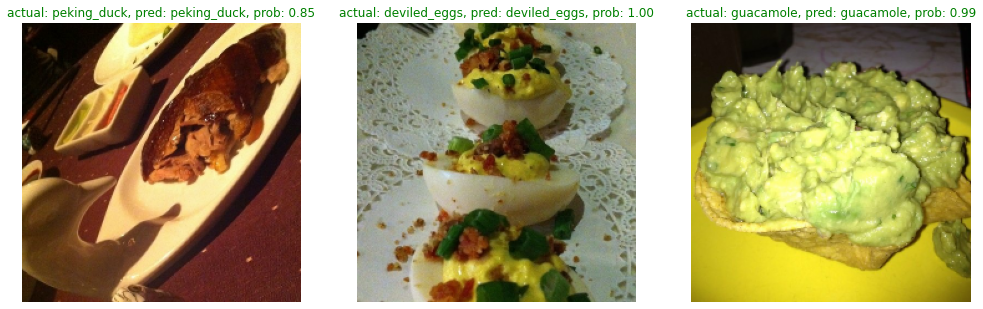

In [44]:
# Make predictions on and plot custom food images
from helper_functions import load_and_prep_image
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir("test/" + class_name))
  filepath = "test/" + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);